# Simplicifaction transformations on cityscapes dataset
The objective of this notebook is to find out the right transformations to
simplify and prepare the cityscapes dataset for the initial "lite" learning
process, in order to make inferences aout the model and assume its behaviour
 in a more complex scenario

In [16]:
import matplotlib.pyplot as plt
import os

import numpy as np
import torch
from PIL import Image

import cityscapesscripts.helpers.labels as labels

## 1. Reduce the number of classes

Let's read one annotation from the trainig set to work with:

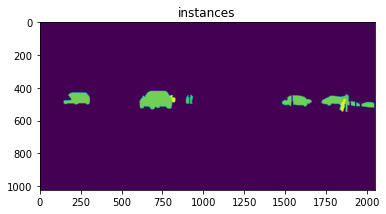

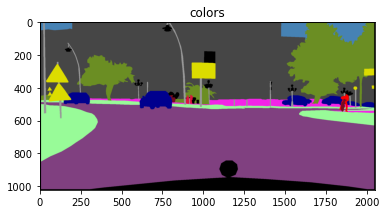

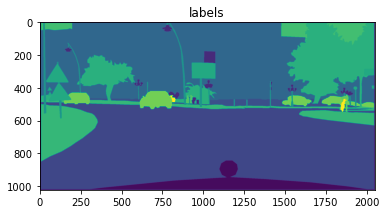

In [5]:
train_data_root = "../data/cityscapes/gtFine/train"
anot_base_path = os.path.join(train_data_root, "aachen")
anot_inst_path = os.path.join(anot_base_path,
                              "aachen_000000_000019_gtFine_instanceIds"
                                              ".png")
anot_color_path = os.path.join(anot_base_path,
                              "aachen_000000_000019_gtFine_color"
                                              ".png")
anot_labels_path = os.path.join(anot_base_path,
                              "aachen_000000_000019_gtFine_labelIds"
                                              ".png")

img_inst = np.array(Image.open(anot_inst_path))
img_color = np.array(Image.open(anot_color_path))
img_label = np.array(Image.open(anot_labels_path))

plt.figure()
plt.title("instances")
plt.imshow(img_inst)
plt.figure()
plt.title("colors")
plt.imshow(img_color)
plt.figure()
plt.title("labels")
plt.imshow(img_label)

We can see that instance information is displaying mostly cars and humans,
which are one of the base instances and therefore most important. Label and
color information gives the pretty much same daa with diferrent value
representation, including all 35 classes.

Let's check the number of uniwue pixl elements on all this images to
determine how many classes/instances are on this picture:

In [6]:
print("Instance view:")
print("Count: ", len(np.unique(img_inst)))
print(np.unique(img_inst))
print()

print("color view:")
print("Count: ", len(np.unique(img_color)))
print(np.unique(img_color))
print()

print("label view:")
print("Count: ", len(np.unique(img_label)))
print(np.unique(img_label))

Instance view:
Count:  25
[    0     1     3     4     7     8    11    17    20    21    22    23
 24000 24001 25000 26003 26004 26005 26006 26007 26008 26009 26010 33000
 33001]

color view:
Count:  21
[  0  11  20  32  35  60  64  70 107 119 128 130 142 152 153 180 220 232
 244 251 255]

label view:
Count:  16
[ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]


Now we can draw some conclusions. In instance view, we have 25 seperate
instances, but if we look closely we have only 16 classes, which is ok since
 some classes are allowed to diferentiate multiple instances (vehicles,
 people) and most of them are not.

 In the color view we have 21 different values, probably becaues of some
 background elements that are excluded in other views.

 Finally in label view we can confirm that we have 16 unique classes on the
 image.


 From now on we will be working mainly with the instance view. In order to
 simlify the number of classes, we need to acces the labels in the
 cityscapes scripts that contain index-category mapping for each label We
 will then construct a function that takes a values from the original
 instance view and transofrms it in order. Note that we need to kep the
 instance ids (005, 006 etc.) i order to achieve the full instance
 segmentation task.

Count:  18
0: 0.0609593391%
1: 0.4102120399%
2: 0.2917947769%
3: 0.0275177956%
4: 0.1677699089%
5: 0.0184640884%
6000: 0.0013995171%
6001: 0.0004401207%
7000: 0.0003957748%
7001: 0.0007052422%
7003: 0.0010151863%
7004: 0.0007801056%
7005: 0.0028953552%
7006: 0.0000562668%
7007: 0.0006165504%
7008: 0.0025024414%
7009: 0.0041670799%
7010: 0.0083084106%


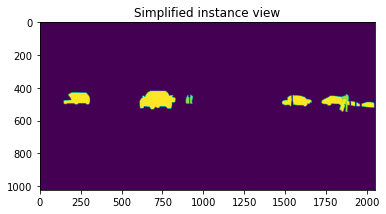

In [7]:
label_dict = labels.id2label

def simplify(x):
    if x > 1000:
        x_cat = label_dict[int(np.floor(x/1000))].categoryId
        x_inst = x%1000
        return x_cat * 1000 + x_inst

    return label_dict[x].categoryId

transformation = lambda x: simplify(x)
vfunc = np.vectorize(transformation)
simple_inst = vfunc(img_inst)

plt.figure()
plt.title("Simplified instance view")
plt.imshow(simple_inst)

print("Count: ", len(np.unique(simple_inst)))
unique, cts = np.unique(simple_inst, return_counts=True)
num_pixel = simple_inst.shape[0] * simple_inst.shape[1]
for elem, count in zip(unique, cts):
    print("%d: %.10f%%" % (elem, count/num_pixel))

That was the class reduction transformation. Our next task is to prepare the
 data for the pre-rained PyTorch Mask R-CNN model.

## 2. Prepare the data for Mask R-CNN model

We can take he simplified istance mask and modify it for the pre-trained
torchvision Mask R-CNN model.

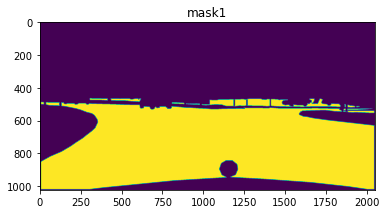

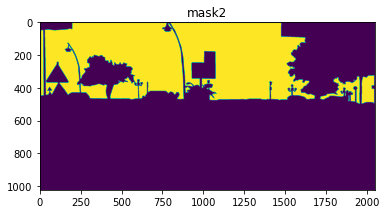

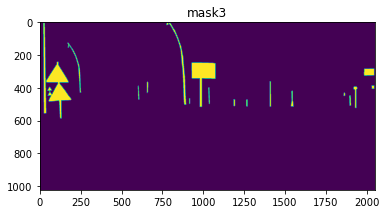

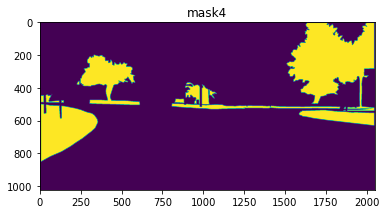

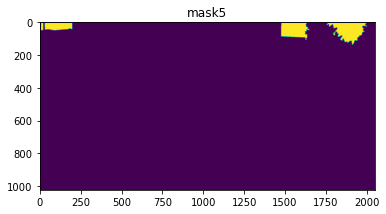

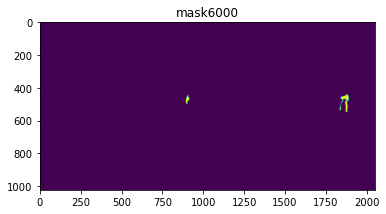

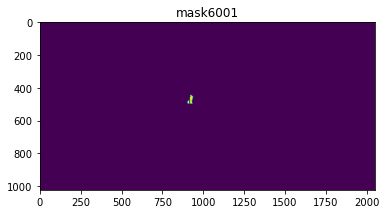

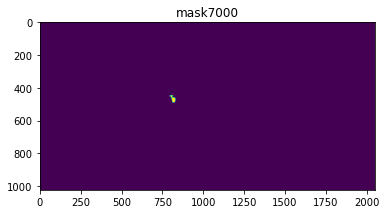

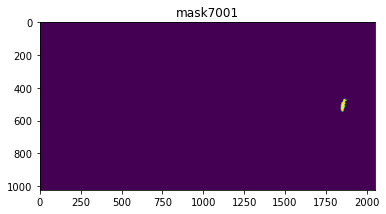

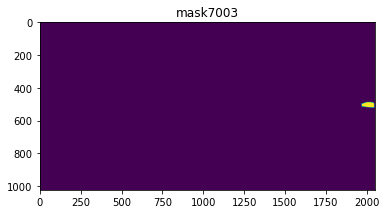

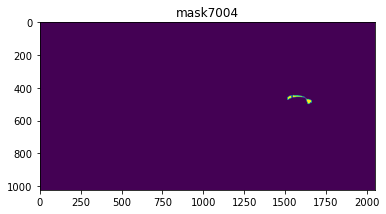

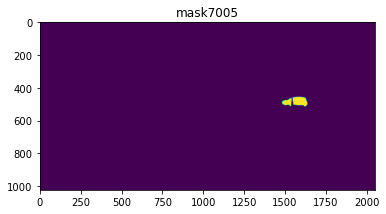

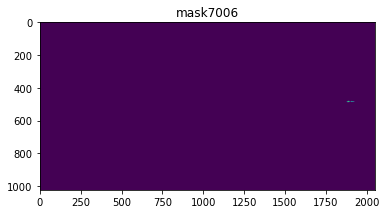

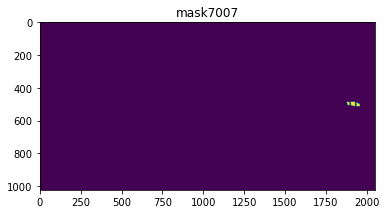

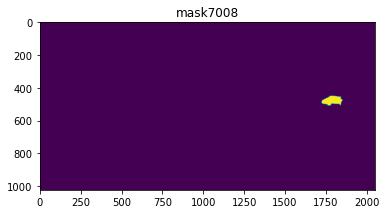

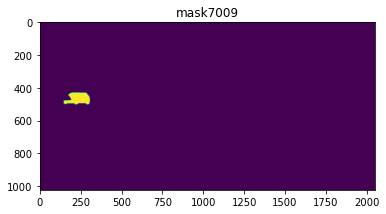

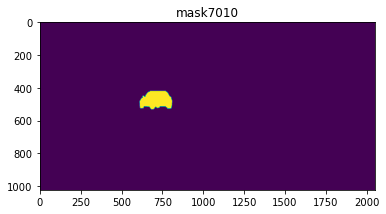

In [14]:
obj_ids = np.unique(simple_inst) #instances are encoded with diferent "colors"
obj_ids = obj_ids[1:] #remove the id 0, which is background and noise

# split the color-encoded mask into a set
# of binary masks
masks = simple_inst == obj_ids[:, None, None]
for mask, i in zip(masks, obj_ids):
    plt.figure()
    plt.title("mask" + str(i))
    plt.imshow(mask)

In [19]:
# get bounding box coordinates for each mask
boxes = []
for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    boxes.append([xmin, ymin, xmax, ymax])

# convert everything into a torch.Tensor
boxes = torch.as_tensor(boxes, dtype=torch.float32)

# there is only one class
labels = [i if i < 1000 else int(i/1000) for i in obj_ids]

labels = torch.as_tensor(labels, dtype=torch.int32)
masks = torch.as_tensor(masks, dtype=torch.uint8)

area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
# suppose all instances are not crowd
iscrowd = torch.zeros((len(obj_ids),), dtype=torch.int64)

target = {}
target["boxes"] = boxes
target["labels"] = labels
target["masks"] = masks
#target["image_id"] = image_id
target["area"] = area
target["iscrowd"] = iscrowd